# Problem Statement:
## Task 2

The bit-flip code and the sign-flip code (you can find a description of both [here](https://en.wikipedia.org/wiki/Quantum_error_correction)) are two very simple circuits able to detect and fix the bit-flip and the sign-flip errors, respectively.

1. Build the following simple circuit to prepare the Bell state:

![Bell State generating circuit](bell-circuit.png)

2. Now add, right before the CNOT gate and for each of the two qubits, an arbitrary "error gate". By error gate, we mean that with a certain probability (that you can decide but must be non-zero for all the choices) you have a 1-qubit unitary which can be either the identity, or the $X$ gate (bit-flip error) or the $Z$ gate (sign-flip error).
3. Encode each of the two qubits with a sign-flip or bit-flip code, in such a way that **all the possible** choices for the error gates described in (2), occurring on the logical qubits, can be detected and fixed. Motivate your choice. This is the most non-trivial part of the problem, so do it with a lot of care!
4. Test your solution by making measurements over the final state and testing that the results are in line with the expectation.


In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import execute, Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram

import numpy as np

from matplotlib import pyplot as plt

%matplotlib inline

sv_sim = Aer.get_backend('statevector_simulator')
qasm_sim = QasmSimulator(method='extended_stabilizer')

# 1. Circuit with no errors

In [2]:
qc = QuantumCircuit(2)    # Create the quantum circuit object with 2 qubits
qc.h(0)                   # Add a Hadamard gate on the first qubit
qc.cx(0,1)                # Add a CNOT gate with first qubit as control and second as target

qc.draw()                 # Display the circuit

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

#### Running Circuit 1

With no errors, this circuit should produce the Bell state:
$$ |\beta_{00}\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}} $$

Upon measuring this state, we should observe these statistics:

|**Measured State**|**Probability**|
|:----------------:|--------------:|
|00|0.5|
|01|0.0|
|10|0.0|
|11|0.5|

Output state vector:  [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


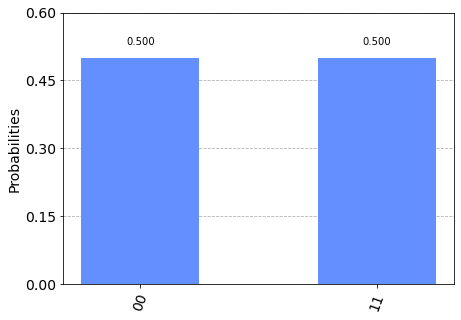

In [3]:
result = execute(qc,sv_sim).result()
print('Output state vector: ', result.get_statevector())

counts = result.get_counts()
plot_histogram(counts)

### 2. Circuit prone to errors, without error correction

Now, each qubit is subject to a random error before the CNOT gate. For each qubit the probability of encountering an $X$ error is $p$, the probability of encountering a $Z$ error is $p$ and thus, the probability of no error is $1-2p$.

You can adjust the value of p in the cell below:

In [4]:
p=0.3

The next cell defines a function that will add a random error gate the circuit.

* `qubit`: The index of the qubit to add the error gate to
* `prob`: The probability of the error gates occuring (assumes every error is equally likely)
* `error_gates`: A list of possible error gates (pass in the form `[quantumCircuit.gate0, ...]`)

In [5]:
def addDiscreteErrorGate(qubit, prob, error_gates):
    n = len(error_gates)
    
    # Check to make sure n*prob<=1
    if(n*prob > 1):
        raise ValueError('The entered probability is invalid, {}*prob > 1'.format(n))
    
    rand = np.random.uniform(0,1)
    #print(rand) # Debugging line
    
    # Apply error_gate[i] if the randomly generated number is between i*prob and (i+1)*prob
    for i in range(n):
        if rand < (i+1)*prob:
            error_gates[i](qubit)
            return
    

The next cell defines a circuit that implements this random error.

In [9]:
def genCircuit2(prob):
    qc = QuantumCircuit(2)
    qc.h(0)

    # Adds error gates after the Hadamard
    addDiscreteErrorGate(0,prob,[qc.x, qc.z])
    addDiscreteErrorGate(1,prob,[qc.x, qc.z])

    qc.cx(0,1)
    
    return qc

qc=genCircuit2(p)
qc.draw()

┌───┐┌───┐     
q_0: ┤ H ├┤ X ├──■──
     ├───┤└───┘┌─┴─┐
q_1: ┤ Z ├─────┤ X ├
     └───┘     └───┘

Output state vector:  [ 0.70710678+0.j -0.        +0.j -0.        +0.j  0.70710678+0.j]


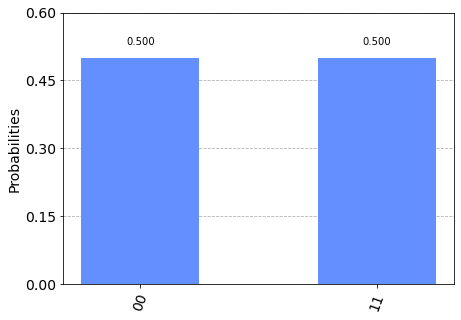

In [10]:
result = execute(qc,sv_sim).result()
print('Output state vector: ', result.get_statevector())

counts = result.get_counts()
plot_histogram(counts)

#### Running Circuit 2

In the above cell I displayed the output state and measurement statistics of **one instance** of Circuit 2. Since there are multiple possible ways in which the error can manifest in this circuit, it would make more sense to look at the fidelity of the circuit.

Fidelity is a measure of "how close" two quantum states are. For the pure state $|\psi\rangle$, that is the output of the error-prone circuit, and $|\phi\rangle$ that is the output of the error-free circuit, the fidelity is calculated as:
$$ F = |\langle \psi | \phi \rangle |^2 $$

We can measure the average fidelity by doing the above calculation for multiple instances of Circuit 2.

In [11]:
N = 250 # Number of noisy circuits to generate

# Expected state vector
phi = np.array([(1.0+0.0j)/np.sqrt(2),0.0j,0.0j,(1.0+0.0j)/np.sqrt(2)])

# Different values of p we'll simulate
probs = np.linspace(0,0.5,20)

# Holds the measured fidelity values
F = []

for prob in probs:
    fidelities = []
    for i in range(N):
        qc = genCircuit2(prob)
        psi = execute(qc,sv_sim).result().get_statevector()
    
        fidelities.append(np.abs(np.vdot(psi,phi))**2)
    F.append(np.average(fidelities))

Given that they occur immediately after the Hadamard gate, the $X$ and $Z$ errors can only map the output onto one of the Bell states. The inner product $\langle\phi|\psi\rangle = 1$ if $|\psi\rangle=|\beta_{00}\rangle$, and $0$ otherwise and the fidelities take on the same values.

The errors that keep the output $|\beta_{00}\rangle$ are: $I_1I_2, I_1Z_2, X_1I_2,$ and $X_1Z_2 $ and so the expected fidelity for Circuit 2 can be calculated:
$$ F = (1-2p)^2 + (1-2p)p + p(1-2p) + p^2 = 1 - 2p + p^2 $$

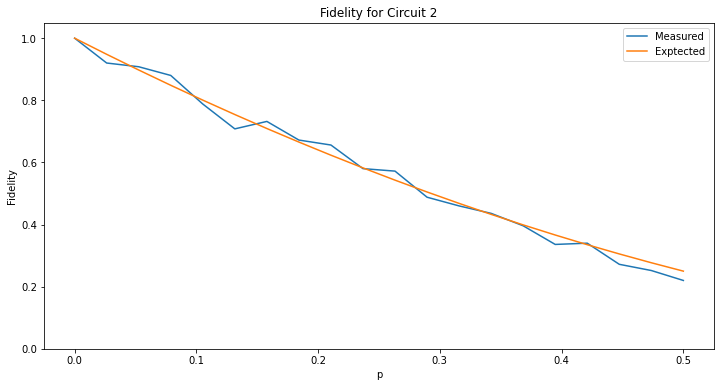

In [12]:
expected = 1 - 2*probs + probs**2 

fig = plt.figure(figsize=(12,6))

plt.title('Fidelity for Circuit 2')

plt.plot(probs,F,label='Measured')
plt.plot(probs,expected,label='Exptected')

plt.xlabel('p')
plt.ylabel('Fidelity')

plt.ylim([0,1.05])

plt.legend()

### 3. Error Correcting Code

I'll be using the Steane 7-qubit code to do error correction because it can correct any arbitrary single-qubit error and the logical Hadamard and CNOT gates are very easy to implement in this error correction scheme.

#### Code Subspace and Logical Qubit States
In order to perform error correction using the Steane code, we map the space of single qubit states onto a subspace of 7-qubit states, henceforth refered to as the '_code subspace_'. We refer to the register of 7 physical qubits as one _logical qubit_. I'll use an overline to signify that the vectors and operators are logical analogs to the physical vectors and operators.

For example, the logical $|0\rangle$ state is:

$$ |\bar{0}\rangle = \frac{1}{\sqrt{8}} \left[
|0000000\rangle + 
|1010101\rangle + 
|0110011\rangle + 
|1100110\rangle + 
|0001111\rangle + 
|1011010\rangle + 
|0111100\rangle + 
|1101001\rangle
\right]
$$

and the logical $X$ and $Z$ gates are:
$$ \bar{X} = X_1 X_2 X_3 X_4 X_5 X_6 X_7 $$
$$ \bar{Z} = Z_1 Z_2 Z_3 Z_4 Z_5 Z_6 Z_7 $$

#### Measuring Logical Qubits
If $\bar{M}$ is an observable on seven qubits with eigenvalues $\pm 1$, its measurement projectors can be written in the form
$$ \frac{I \pm \bar{M}}{\sqrt{2}} $$

With the help an ancilla qubit, we can measure $\bar{M}$ the following circuit:

![General Measurement Circuit](general-measurement-circuit.png)

Measuring the ancilla as 0 corresponds to measuring the eigenvalue +1 and measuring the ancilla as 1 corresponds to measuring the eigenvalue -1. The 7-qubit register will be projected into the corresponding eigenspace of $\bar{M}$ after measurement.

#### Error Correction and Initializing the Logical $|0\rangle$ State
The following operators are called the '_Stabilizer Generators_' of the Steane code:

Name|Operator
----|--------
$g_1$|$I_1 I_2 I_3 X_4 X_5 X_6 X_7$
$g_2$|$I_1 X_2 X_3 I_4 I_5 X_6 X_7$
$g_3$|$X_1 I_2 X_3 I_4 X_5 I_6 X_7$
$g_4$|$I_1 I_2 I_3 Z_4 Z_5 Z_6 Z_7$
$g_5$|$I_1 Z_2 Z_3 I_4 I_5 Z_6 Z_7$
$g_6$|$Z_1 I_2 Z_3 I_4 Z_5 I_6 Z_7$

They are all observables with eigenvalues $\pm 1$. The code subspace is the intersection of their +1 eigenspaces, i.e. a successive measurement of +1 for each of these operators will project the logical qubit into the code subpace.

Since each $g_i$ is a tensor product of $I$, $X$ and $Z$, we can controlled-$g_i$s for measurement using CNOT and CZ gates.

We use this property to do error correction. The eigenvalues measured for all of the $g_i$'s are collectively called the '_syndrome_' of the measurement. Although, it is more convenient for us to refer to the measured bits instead (remember +1 corresponds to 0 and -1 corresponds to 1).
If the syndrome is not all 0s, then we need to apply some corrective gates to project the logical qubit into the code space.

The measurements for $g_1,g_2,g_3$ read left to right as a binary integer tell us the index of the qubit to apply a corrective $Z$ gate to.

And likewise, the measurements for $g_4,g_5,g_6$ read left to right as a binary integer tell us the index of the qubit to apply a corrective $X$ gate to.

![Error Correction Circuit](steane-measure-circuit.png)

These corrections will project the logical qubit into the code subspace. In particular, if we start with the logical qubit in the $|0000000\rangle$ state, under these corrections, it will be projected into the logical 0 state $|\bar{0}\rangle$.

In [13]:
def error_correction(qc, x_ancillas, z_ancillas, logical_qubit, x_syndrome, z_syndrome):
    # Make sure inputs are valid
    if not isinstance(qc, QuantumCircuit):
        raise TypeError("'qc', should be a QuantumCircuit")
    
    if not isinstance(x_ancillas, QuantumRegister):
        raise TypeError("'x_ancillas' should be a QuantumRegister")
    elif x_ancillas.size != 3:
        raise TypeError("'x_ancillas' must have 3 qubits")
        
    if not isinstance(z_ancillas, QuantumRegister):
        raise TypeError("'z_ancillas' should be a QuantumRegister")
    elif z_ancillas.size != 3:
        raise TypeError("'z_ancillas' must have 3 qubits")
    
    if not isinstance(logical_qubit, QuantumRegister):
        raise TypeError("'logical_qubit' should be a QuantumRegister")
    elif logical_qubit.size != 7:
        raise TypeError("'logical_qubit' must have 7 qubits")
    
    if not isinstance(x_syndrome, ClassicalRegister):
        raise TypeError("'x_syndrome' should be a ClassicalRegister")
    elif x_syndrome.size != 3:
        raise TypeError("'x_syndrome' must have 3 bits")
        
    if not isinstance(z_syndrome, ClassicalRegister):
        raise TypeError("'z_syndrome' should be a ClassicalRegister")
    elif z_syndrome.size != 3:
        raise TypeError("'z_syndrome' must have 3 bits")
        
    # Initialize the ancillas to |0>
    for i in range(3):
        qc.initialize([1,0], x_ancillas[i])
        qc.initialize([1,0], z_ancillas[i])
        
    # Apply Hadamard to the ancillas
    qc.h(x_ancillas)
    qc.h(z_ancillas)
    
    # Controlled g_i
    qc.cx(z_ancillas[2], [logical_qubit[i-1] for i in [4,5,6,7]]) # Controlled g1
    qc.cx(z_ancillas[1], [logical_qubit[i-1] for i in [2,3,6,7]]) # Controlled g2
    qc.cx(z_ancillas[0], [logical_qubit[i-1] for i in [1,3,5,7]]) # Controlled g3
    
    qc.cz(x_ancillas[2], [logical_qubit[i-1] for i in [4,5,6,7]]) # Controlled g4
    qc.cz(x_ancillas[1], [logical_qubit[i-1] for i in [2,3,6,7]]) # Controlled g5
    qc.cz(x_ancillas[0], [logical_qubit[i-1] for i in [1,3,5,7]]) # Controlled g6
    
    # Apply Hadamard to the ancillas
    qc.h(x_ancillas)
    qc.h(z_ancillas)
    
    # Measure the ancillas
    qc.measure(x_ancillas, x_syndrome)
    qc.measure(z_ancillas,z_syndrome)
    
    # Apply the corrective X gates
    for i in range(1,8):
        qc.x(logical_qubit[i-1]).c_if(x_syndrome,i)
    
    # Apply the corrective Z gates
    for i in range(1,8):
        qc.z(logical_qubit[i-1]).c_if(z_syndrome,i)

In [14]:
# Verifying that this error correction will generate the logical 0 state

lq = QuantumRegister(7)
x_anc  = QuantumRegister(3)
x_syn  = ClassicalRegister(3)
z_anc  = QuantumRegister(3)
z_syn  = ClassicalRegister(3)

qc = QuantumCircuit(x_anc,z_anc,lq,x_syn,z_syn)
error_correction(qc, x_anc, z_anc, lq, x_syn, z_syn)

result = execute(qc, sv_sim).result()
sv = result.get_statevector()

# list that holds the computational basis vector names where the amplitude is non-zero
indices = []       
for i in range(len(sv)):
    if sv[i] != 0:
        # store the index as a 10-bit long binary number
        indices.append( ((str(bin(i)[2:]).zfill(3+7)),sv[i]) )
        
print('Number of kets in superposition: ', len(indices))
print("Kets in superposition:")
for i in indices:
    print('Ket:', i[0][0:7][::-1], '--- Amplitude:', i[1] ) # Extract the 7 left-most bits of the number, 
                                                            # reverse them (for consistency with the notes)
                                                            # and print the amplitude of the ket

print('\nsqrt[1/8] =',np.sqrt(1/8))                        # To verify the amplitudes are correct

Number of kets in superposition:  8
Kets in superposition:
Ket: 1110000 --- Amplitude: (0.35355339059327373-6.494670421766201e-17j)
Ket: 1101111 --- Amplitude: (0.35355339059327373-1.5154230984121137e-16j)
Ket: 1101101 --- Amplitude: (0.35355339059327373-1.5154230984121137e-16j)
Ket: 1110011 --- Amplitude: (0.35355339059327373-1.515423098412114e-16j)
Ket: 1101001 --- Amplitude: (0.35355339059327373-1.9484011265298604e-16j)
Ket: 1010101 --- Amplitude: (0.35355339059327373-1.082445070294367e-16j)
Ket: 0110011 --- Amplitude: (0.35355339059327373-1.0824450702943669e-16j)
Ket: 0001111 --- Amplitude: (0.35355339059327373-1.0824450702943669e-16j)

sqrt[1/8] = 0.3535533905932738


Verify that the kets in the output above match the the statevector match the logical $|0\rangle$ state
$$ |\bar{0}\rangle = \frac{1}{\sqrt{8}} \left[
|0000000\rangle + 
|1010101\rangle + 
|0110011\rangle + 
|1100110\rangle + 
|0001111\rangle + 
|1011010\rangle + 
|0111100\rangle + 
|1101001\rangle
\right],
$$

#### Applying Gates in the Code Subspace
As mentioned earlier, the logical $X$ and $Z$ gates for the Steane code are:
$$ \bar{X} = X_1X_2X_3X_4X_5X_6X_7 $$
$$ \bar{Z} = Z_1Z_2Z_3Z_4Z_5Z_6Z_7 $$

##### Logical Hadamard Gate
For a single qubit, the Hadamard gate has the folliwing properties:
$$ HXH = Z $$
$$ HZH = X $$
and so the logical Hadamard gate acting on the code space must follow the first two properties for the logical $X$ and $Z$ gates:
$$ \bar{H}\bar{X}\bar{H} = \bar{Z} $$
$$ \bar{H}\bar{Z}\bar{H} = \bar{X} $$

$$ \bar{H} = H_1 H_2 H_3 H_4 H_5 H_6 H_7 $$ 
clearly satisfies this property and can be used as the logical Hadamard gate.

In [15]:
# Adds the logical Hadamard  gate to a QuantumCircuit qc
def logical_h(qc, logical_qubit):
    if not isinstance(qc, QuantumCircuit):
        raise TypeError("'qc', should be a QuantumCircuit")
        
    if not isinstance(logical_qubit, QuantumRegister):
        raise TypeError("'logical_qubit' should be a QuantumRegister")
    elif logical_qubit.size != 7:
        raise TypeError("'logical_qubit' must have 7 qubits")

    qc.h(logical_qubit)

##### Logical CNOT Gate
The logical CNOT can be implemented in the Steane code subspace by taking individual CNOTS controlled by each of the qubits in the first logical register targetting the qubits sharing the same index in the second logical qubit

In [16]:
# Adds the logical CNOT gate to a QuantumCircuit qc with logical qubit 'control' as the control
# and 'target' as target
def logical_cx(qc, control, target):
    if not isinstance(qc, QuantumCircuit):
        raise TypeError("'qc', should be a QuantumCircuit")
        
    if not isinstance(control, QuantumRegister):
        raise TypeError("'control' should be a QuantumRegister")
    elif control.size != 7:
        raise TypeError("'control' must have 7 qubits")
    
    if not isinstance(control, QuantumRegister):
        raise TypeError("'control' should be a QuantumRegister")
    elif control.size != 7:
        raise TypeError("'control' must have 7 qubits")

    for i in range(7):
        qc.cx(control[i],target[i])

#### Measuring the Logical Qubits in the Z-basis
As using the same measurement outline as before, we can measure a logical qubit in the $Z$-basis by
replacing $\bar{M}$ with $\bar{Z}$:

In [17]:
# Measures logical_qubit in the Z basis using ancilla, in the circuit qc
def logical_z_measure(qc, ancilla, logical_qubit, measurement):
    # Make sure the inputs are valid
    if not isinstance(qc, QuantumCircuit):
        raise TypeError("'qc' should be a QuantumCircuit")
    
    if not isinstance(ancilla, QuantumRegister):
        raise TypeError("'ancilla' should be a QuantumRegister")
    elif ancilla.size != 1:
        raise TypeError("'ancilla' must have 1 qubit")
    
    if not isinstance(logical_qubit, QuantumRegister):
        raise TypeError("'logical_qubit'should be a QuantumRegister")
    elif logical_qubit.size != 7:
        raise TypeError("'logical_qubit' must have 7 qubits")
    
    if not isinstance(measurement, ClassicalRegister):
        raise TypeError("'measurement' should be a ClassicalRegister")
    elif measurement.size != 1:
        raise TypeError("'measurement' must have 1 bit")
        
    # Initialize ancilla to |0>
    qc.initialize([1,0],ancilla)
    
    # Apply Hadamard to ancilla
    qc.h(ancilla)
    # Apply controlled logical-Z
    for i in range(7):
        qc.cz(ancilla, logical_qubit[i])
    # Apply Hadamard to ancilla
    qc.h(ancilla)
    
    # Measure the ancilla
    qc.measure(ancilla, measurement)

#### Error Correcting Circuit
Although in the problem statement we know to expect an error between the Hadamard and CNOT, it makes more sense to detect and correct for errors after every operation.

In [18]:
# error_levels:
# 0 - No errors
# 1 - Exactly one bit flip and one phase flip error on any one physical qubit of each logical qubit
# 2 - Bit and Phase flip possible on every physical qubit

def BellCircuit_With_EC(error_prob=0, error_level=0):
    # The logical qubits
    lq_1 = QuantumRegister(7,name='lq_1')
    lq_2 = QuantumRegister(7,name='lq_2')

    # Error Correction Ancillas
    x_ec_ancilla = QuantumRegister(3,name='x_ec_ancil')
    z_ec_ancilla = QuantumRegister(3,name='z_ec_ancil')
    
    x_ec_syndrome = ClassicalRegister(3,name='x_ec_synd')
    z_ec_syndrome = ClassicalRegister(3,name='z_ec_synd')
    
    # Measurement Ancillas
    z_meas_ancilla_1 = QuantumRegister(1,name='meas_ancil_1')
    z_meas_ancilla_2 = QuantumRegister(1,name='meas_ancil_2')

    z_meas_1 = ClassicalRegister(1,name='meas 1')
    z_meas_2 = ClassicalRegister(1,name='meas 2')

    # Define the quantum circuit on these registers
    qc = QuantumCircuit(lq_1, lq_2,
                        x_ec_ancilla, z_ec_ancilla, z_meas_ancilla_1, z_meas_ancilla_2,
                        x_ec_syndrome, z_ec_syndrome, z_meas_1, z_meas_2)
    
    # A function to introduce error dependent on the error_level
        # post_H is a flag for error_level=1, to check if the function is called right 
        # after the Hadamard
    def introduce_error():
        if not isinstance(error_level, int):
            raise TypeError("'error_level' must be an integer")
        if error_level < 0 or error_level > 3:
            raise ValueError("'error_level' must be between 0 and 3, inclusive")
        
        if error_level == 0: # no error
            return
        
        if error_level == 1: # Exactly one error anywhere
            qc.x(lq_1[np.random.randint(0,6+1)])
            qc.z(lq_1[np.random.randint(0,6+1)])

            qc.x(lq_2[np.random.randint(0,6+1)])
            qc.z(lq_2[np.random.randint(0,6+1)])
            return
        
        if error_level == 2: # Bit/Phase flips possible on every physical qubit
            for i in range(7):
                addDiscreteErrorGate(lq_1[i], error_prob, [qc.x, qc.z])
                addDiscreteErrorGate(lq_1[i], error_prob, [qc.x, qc.z])
            return
    
    # Initialize the logical qubits to the 0 state
    error_correction(qc, x_ec_ancilla, z_ec_ancilla, lq_1, x_ec_syndrome, z_ec_syndrome)
    error_correction(qc, x_ec_ancilla, z_ec_ancilla, lq_2, x_ec_syndrome, z_ec_syndrome)

    # Apply the Hadamard gate
    logical_h(qc, lq_1)    
    introduce_error()
    
    error_correction(qc, x_ec_ancilla, z_ec_ancilla, lq_1, x_ec_syndrome, z_ec_syndrome)
    error_correction(qc, x_ec_ancilla, z_ec_ancilla, lq_2, x_ec_syndrome, z_ec_syndrome)

    # Apply the CNOT gate
    logical_cx(qc, lq_1, lq_2)
    introduce_error()
    
    error_correction(qc, x_ec_ancilla, z_ec_ancilla, lq_1, x_ec_syndrome, z_ec_syndrome)
    error_correction(qc, x_ec_ancilla, z_ec_ancilla, lq_2, x_ec_syndrome, z_ec_syndrome)

    # Measure the qubits
    logical_z_measure(qc, z_meas_ancilla_1, lq_1, z_meas_1)
    logical_z_measure(qc, z_meas_ancilla_2, lq_2, z_meas_2)
    
    return qc

# Verifying the results

In [19]:
N = 100   # Number of noisy circuits generated
p = 0.1   # Probability of an error, max 0.5 because the error can be X or Z

## Error Level 0 - Error-free circuit 

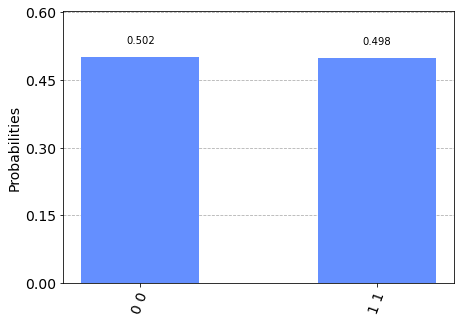

In [21]:
# Error Level 0

net_counts = {}
for i in range(N):
    # Generate a noisy circuit
    qc = BellCircuit_With_EC(p,0)
    
    # Get measurement outcomes
    result = execute(qc, qasm_sim).result()
    counts = result.get_counts()

    # We want to extract only the final measurements, which are the right-most 2 bits 
    # in the counts dictionary key string
    for key in counts.keys():
        # truncate the measurement string to include the Z-measurements
        truncated_key = key[0:3][::-1] # Reversed to match order lq_1 lq_2
        if truncated_key in net_counts.keys():
            net_counts[truncated_key] += counts[key]
        else:
            net_counts[truncated_key] = counts[key]

plot_histogram(net_counts)

## Error Level 1 - Exactly one bit flip and phase flip per logical qubit 

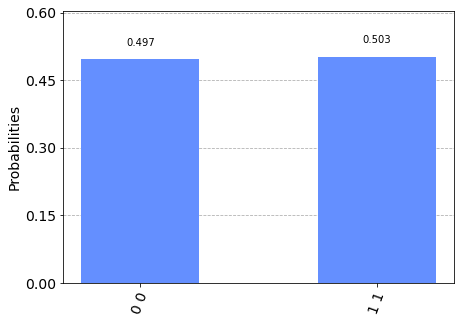

In [22]:
# Error Level 1

net_counts = {}
for i in range(N):
    # Generate a noisy circuit
    qc = BellCircuit_With_EC(p,1)
    
    # Get measurement outcomes
    result = execute(qc, qasm_sim).result()
    counts = result.get_counts()

    # We want to extract only the final measurements, which are the right-most 2 bits 
    # in the counts dictionary key string
    for key in counts.keys():
        # truncate the measurement string to include the Z-measurements
        truncated_key = key[0:3][::-1] # Reversed to match order lq_1 lq_2
        if truncated_key in net_counts.keys():
            net_counts[truncated_key] += counts[key]
        else:
            net_counts[truncated_key] = counts[key]

plot_histogram(net_counts)

## Error Level 2 - Bit/Phase flip possible on every physical qubit 

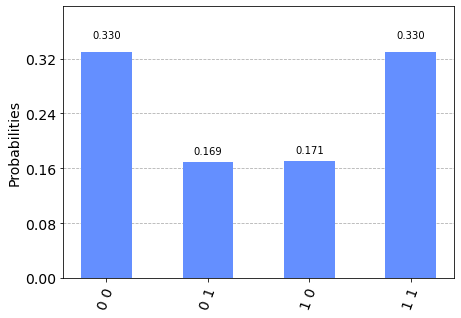

In [23]:
# Error Level 2

net_counts = {}
for i in range(N):
    # Generate a noisy circuit
    qc = BellCircuit_With_EC(p,2)
    
    # Get measurement outcomes
    result = execute(qc, qasm_sim).result()
    counts = result.get_counts()

    # We want to extract only the final measurements, which are the right-most 2 bits 
    # in the counts dictionary key string
    for key in counts.keys():
        # truncate the measurement string to include the Z-measurements
        truncated_key = key[0:3][::-1] # Reversed to match order lq_1 lq_2
        if truncated_key in net_counts.keys():
            net_counts[truncated_key] += counts[key]
        else:
            net_counts[truncated_key] = counts[key]

plot_histogram(net_counts)